# Importación de librerías

In [1]:
import torch
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from SAGE_model import GraphSAGE
from train_eval import train, evaluate, EarlyStopping, predict
from Data_loader import load_dataset
from explainer import run_full_gnnexplainer
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


## Configuración del modelo

In [ ]:
# Configuración del modelo
config = {
    "input_dim": 2,           # 2 canales: Q_heaters, T_env
    "hidden_dim": 128,
    "output_dim": 1,
    "num_layers": 4,
    "use_dropout": True,
    "dropout_rate": 0.057750163502822735,
    "use_batchnorm": True,
    "use_residual": True,
    "batch_size": 64,
    "lr": 0.0013660733299701328,
    "max_epochs": 10000,
    "early_stop_patience": 100,
    "error_threshold_K": 3.0,
    "save_model": True,
    "load_model": False, # Cargar un modelo preentrenado
    "factor" : 0.5 , # Factor de reducción del learning rate
    "patience" : 10 , # Épocas sin mejora para reducir el learning rate
    "min_lr" : 1e-9,  # evita que baje infinitamente el learning rate
    "use_physics" : False,
    "lambda_physics" : 0.0001, # Peso de la física en la función de pérdida
    "use_heater_loss" : True,
    "lambda_heater" : 1.0,
    "comb_loss_epoch_start":50
}

In [4]:
model = GraphSAGE(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número total de parámetros entrenables: {num_params}")

optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',            # queremos minimizar el val_loss
    factor=config["factor"],            # reduce a la mitad el LR
    patience=config["patience"],           # espera 10 épocas sin mejora
    verbose=True,          # imprime info cuando reduce
    min_lr=config["min_lr"]            # evita que baje infinitamente
)


Número total de parámetros entrenables: 67457


c:\Users\ramse\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Cargar Dataset

In [5]:
dataset_path = os.path.join("Datasets3D", "Dataset3D_BI_10000_model.pth")

train_loader, val_loader, _, norm_info = load_dataset(
    path=dataset_path,
    batch_size=config["batch_size"]
)
# Sobrescribimos el test_loader con batch=1 para evaluación por grafo
_, _, test_loader, _ = load_dataset(
    path=dataset_path,
    batch_size=1
)

print("Dataset loaded successfully.")
print("Number of training samples:", len(train_loader.dataset))

sample = train_loader.dataset[0]
print("Input shape (x):", sample.x.shape)
print("Target shape (y):", sample.y.shape)
print("Edge index shape:", sample.edge_index.shape)
print("Edge attr shape:", sample.edge_attr.shape)

print(f"Max Qi: {norm_info['max_Qi']}, Max T_env: {norm_info['max_T_env']}, Max T_real: {norm_info['max_T_real']}")



# 1) Escala de x
print("Node x min/max:", sample.x.min(), sample.x.max())


c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\ia_thermal\ernestoemedina3D\SAGE_3D\Data_loader.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_bundle

Dataset loaded successfully.
Number of training samples: 8000
Input shape (x): torch.Size([34, 2])
Target shape (y): torch.Size([34, 1])
Edge index shape: torch.Size([2, 396])
Edge attr shape: torch.Size([396, 2])
Max Qi: 14.0, Max T_env: 309.999, Max T_real: 335.65639370660637
Node x min/max: tensor(0.) tensor(0.9797)


## Evolución del error vs. Tamaño del Dataset

In [6]:
""" import random
from torch_geometric.loader import DataLoader
# Obtener la lista de grafos completa para submuestreo

data_bundle = torch.load(dataset_path)

# ===  DEFINIR TAMAÑOS A PROBAR ===
dataset_sizes = np.logspace(2, 4, num=6, dtype=int)  # 100 → 10,000
dataset_sizes = np.unique(dataset_sizes)

all_graphs = data_bundle["dataset"]
norm_info = data_bundle["normalization_info"]

print(f"Tamaño total del dataset completo: {len(all_graphs)}")

# ===  DEFINIR TAMAÑOS A PROBAR ===
dataset_sizes = np.logspace(2, 5, num=10, dtype=int)  # 100 a 100,000
dataset_sizes = np.unique(dataset_sizes)

print("\nExplorando influencia del tamaño del dataset en train_loss y val_loss (log scale)...\n")

# ===  ALMACENAR MÉTRICAS ===
train_losses_vs_size = []
val_losses_vs_size = []
train_rmse_real = []
val_rmse_real = []

max_epochs = 100

# ===  BUCLE PRINCIPAL ===
for size in dataset_sizes:
    if size > len(all_graphs):
        print(f"Saltando tamaño {size}: excede el tamaño total del dataset ({len(all_graphs)} muestras)")
        continue

    print(f"\n=== Entrenando con {size} muestras ===")

    # Submuestreo aleatorio
    subset = random.sample(all_graphs, size)
    split_idx = int(0.9 * len(subset))
    train_dataset = subset[:split_idx]
    val_dataset = subset[split_idx:]

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    # === Inicializar modelo ===
    model = GraphSAGE(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
        output_dim=config["output_dim"],
        num_layers=config["num_layers"],
        use_dropout=config["use_dropout"],
        dropout_rate=config["dropout_rate"],
        use_batchnorm=config["use_batchnorm"],
        use_residual=config["use_residual"]
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    # === Entrenamiento ===
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        train_loss = train(
            model, train_loader, optimizer, device, norm_info,
            use_physics=config["use_physics"], lambda_physics=config["lambda_physics"],
            use_heater_loss=config["use_heater_loss"], lambda_heater=config["lambda_heater"]
        )
        train_losses.append(train_loss)

        val_mse, _, _, _, _, _, _, _, _, _ = evaluate(
            model, val_loader, device, norm_info,
            lambda_physics=config["lambda_physics"],
            use_physics=config["use_physics"],
            lambda_heater=config["lambda_heater"],
            use_heater_loss=config["use_heater_loss"],
            error_threshold_K=3.0,
            plot_results=False
        )
        val_losses.append(val_mse)

    # === Guardar métricas ===
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]

    train_losses_vs_size.append(final_train_loss)
    val_losses_vs_size.append(final_val_loss)

    rmse_train_real = (final_train_loss ** 0.5) * norm_info["max_T_real"]
    rmse_val_real = (final_val_loss ** 0.5) * norm_info["max_T_real"]

    train_rmse_real.append(rmse_train_real)
    val_rmse_real.append(rmse_val_real)

    print(f"Final Train Loss: {final_train_loss:.6f} | Train RMSE real: {rmse_train_real:.4f} K")
    print(f"Final Val Loss  : {final_val_loss:.6f} | Val RMSE real  : {rmse_val_real:.4f} K")

print("\n=== Exploración completada ===") """

' import random\nfrom torch_geometric.loader import DataLoader\n# Obtener la lista de grafos completa para submuestreo\n\ndata_bundle = torch.load(dataset_path)\n\n# ===  DEFINIR TAMAÑOS A PROBAR ===\ndataset_sizes = np.logspace(2, 4, num=6, dtype=int)  # 100 → 10,000\ndataset_sizes = np.unique(dataset_sizes)\n\nall_graphs = data_bundle["dataset"]\nnorm_info = data_bundle["normalization_info"]\n\nprint(f"Tamaño total del dataset completo: {len(all_graphs)}")\n\n# ===  DEFINIR TAMAÑOS A PROBAR ===\ndataset_sizes = np.logspace(2, 5, num=10, dtype=int)  # 100 a 100,000\ndataset_sizes = np.unique(dataset_sizes)\n\nprint("\nExplorando influencia del tamaño del dataset en train_loss y val_loss (log scale)...\n")\n\n# ===  ALMACENAR MÉTRICAS ===\ntrain_losses_vs_size = []\nval_losses_vs_size = []\ntrain_rmse_real = []\nval_rmse_real = []\n\nmax_epochs = 100\n\n# ===  BUCLE PRINCIPAL ===\nfor size in dataset_sizes:\n    if size > len(all_graphs):\n        print(f"Saltando tamaño {size}: excede

In [7]:
""" 
# === Configuración global ===
plt.style.use('default')
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.family"] = "Serif"
plt.rcParams["font.size"] = 12
plt.rcParams["text.usetex"] = False  # mientras MiKTeX no funcione bien
plt.rcParams["axes.titlesize"] = 17

# === Gráfica 1: Train Loss (MSE, normalizado) ===
fig1, ax1 = plt.subplots(figsize=(8, 5))  # Más ancho localmente
ax1.plot(dataset_sizes[:len(train_losses_vs_size)],
         train_losses_vs_size,
         marker='o', linestyle='-', label="Train Loss (MSE)")
ax1.plot(dataset_sizes[:len(val_losses_vs_size)], val_losses_vs_size, marker='s', linestyle='--', label="Val Loss (MSE)")

ax1.set_xscale('log')
ax1.set_xlabel('Dataset size for training (log scale)')
ax1.set_ylabel('Training loss (MSE, normalized)')
ax1.set_title('Influence of dataset size on training loss (normalized)')
ax1.grid(True, which="both", ls="--")
ax1.legend()
fig1.tight_layout()
plt.show()

# === Gráfica 2: Train RMSE real en Kelvin ===
fig2, ax2 = plt.subplots(figsize=(8, 5))  # Igual de ancho localmente
ax2.plot(dataset_sizes[:len(train_rmse_real)],
         train_rmse_real,
         marker='o', linestyle='-', label="Train RMSE (K)")
ax2.plot(dataset_sizes[:len(val_rmse_real)], val_rmse_real, marker='s', linestyle='--', label="Val RMSE (K)")

ax2.set_xscale('log')
ax2.set_xlabel('Dataset size for training (log scale)')
ax2.set_ylabel('RMSE Error (K)')
ax2.set_title('Training Error in real scale (RMSE in Kelvin)')
ax2.grid(True, which="both", ls="--")
ax2.legend()
fig2.tight_layout()
plt.show()
 """

' \n# === Configuración global ===\nplt.style.use(\'default\')\nplt.rcParams["figure.figsize"] = (6, 4)\nplt.rcParams["font.family"] = "Serif"\nplt.rcParams["font.size"] = 12\nplt.rcParams["text.usetex"] = False  # mientras MiKTeX no funcione bien\nplt.rcParams["axes.titlesize"] = 17\n\n# === Gráfica 1: Train Loss (MSE, normalizado) ===\nfig1, ax1 = plt.subplots(figsize=(8, 5))  # Más ancho localmente\nax1.plot(dataset_sizes[:len(train_losses_vs_size)],\n         train_losses_vs_size,\n         marker=\'o\', linestyle=\'-\', label="Train Loss (MSE)")\nax1.plot(dataset_sizes[:len(val_losses_vs_size)], val_losses_vs_size, marker=\'s\', linestyle=\'--\', label="Val Loss (MSE)")\n\nax1.set_xscale(\'log\')\nax1.set_xlabel(\'Dataset size for training (log scale)\')\nax1.set_ylabel(\'Training loss (MSE, normalized)\')\nax1.set_title(\'Influence of dataset size on training loss (normalized)\')\nax1.grid(True, which="both", ls="--")\nax1.legend()\nfig1.tight_layout()\nplt.show()\n\n# === Gráfic

## Entrenamiento

In [8]:
# Entrenamiento
train_losses = []
val_losses = []
epoch_times = []

early_stopper = EarlyStopping(patience=config["early_stop_patience"])
max_epochs = config["max_epochs"]
best_lr=config["lr"]
EPOCH_START = config["comb_loss_epoch_start"] # Época a partir de la cual se aplica la física y heater loss

print("Iniciando entrenamiento...")
for epoch in range(config["max_epochs"]):
    start_time = time.time()
    
    # use_physics = epoch >= EPOCH_START
    # use_heater_loss = epoch >= EPOCH_START
    
    # Entrenar
    train_loss = train(model, train_loader, optimizer, device, norm_info, lambda_physics=config["lambda_physics"],
                       use_physics=config["use_physics"], lambda_heater=config["lambda_heater"],
                       use_heater_loss=config["use_heater_loss"],)
    train_losses.append(train_loss)

    # Evaluar en validación
    val_mse, val_mae, val_r2, val_accuracy, val_physics, val_heaters, val_rmse, val_total_loss, val_max_error_K, val_mean_max_error_per_graph_K = evaluate(
        model, val_loader, device, norm_info, lambda_physics=config["lambda_physics"],
        use_physics=config["use_physics"], lambda_heater=config["lambda_heater"],
        use_heater_loss=config["use_heater_loss"],
        error_threshold_K=config["error_threshold_K"],
        plot_results=False
    )
    val_losses.append(val_mse)

    scheduler.step(val_mse)
    
    # Medir tiempo transcurrido
    epoch_duration = time.time() - start_time
    epoch_times.append(epoch_duration)

    # Formatear bien los losses opcionales
    physics_loss_str = f"{val_physics:.6f}" if config["use_physics"] else "N/A"
    heaters_loss_str = f"{val_heaters:.6f}" if config["use_heater_loss"] else "N/A"

    # Imprimir métricas
    print(f"Epoch {epoch + 1} - "
          f"Train Loss: {train_loss:.6f} | "
          f"Val MSE: {val_mse:.6f} | "
          f"Val MAE: {val_mae:.6f} | "
          f"Val R²: {val_r2:.4f} | "
          f"[Heaters loss] {heaters_loss_str} | "
          f"[Physics loss] {physics_loss_str} | "
          f"Val Accuracy: {val_accuracy:.2f}% | "
          f"LR: {optimizer.param_groups[0]['lr']:.9f} | "
          f"Time: {epoch_duration:.2f}s")

    # Guardar el mejor modelo en memoria
    if val_total_loss < early_stopper.best_loss:
        best_model_state = copy.deepcopy(model.state_dict())
        final_epoch = epoch + 1
        best_lr = optimizer.param_groups[0]['lr']  # guardar lr actual

    early_stopper(val_total_loss, epoch)
    if early_stopper.early_stop:
        print(f" Early stopping triggered at epoch {epoch}")
        avg_epoch_time = np.mean(epoch_times)
        print(f"Tiempo por época        : {avg_epoch_time:.2f}")
        break

Iniciando entrenamiento...
Epoch 1 - Train Loss: 0.169688 | Val MSE: 0.002329 | Val MAE: 0.036061 | Val R²: 0.0090 | [Heaters loss] 0.001189 | [Physics loss] N/A | Val Accuracy: 15.65% | LR: 0.001366073 | Time: 3.27s
Epoch 2 - Train Loss: 0.025820 | Val MSE: 0.001704 | Val MAE: 0.034459 | Val R²: 0.2765 | [Heaters loss] 0.001100 | [Physics loss] N/A | Val Accuracy: 14.38% | LR: 0.001366073 | Time: 2.29s
Epoch 3 - Train Loss: 0.016266 | Val MSE: 0.001003 | Val MAE: 0.026591 | Val R²: 0.5750 | [Heaters loss] 0.001088 | [Physics loss] N/A | Val Accuracy: 18.70% | LR: 0.001366073 | Time: 2.63s
Epoch 4 - Train Loss: 0.012408 | Val MSE: 0.002194 | Val MAE: 0.036180 | Val R²: 0.0664 | [Heaters loss] 0.001302 | [Physics loss] N/A | Val Accuracy: 15.39% | LR: 0.001366073 | Time: 2.61s


KeyboardInterrupt: 

### Revisión del output por nodo:

In [ ]:
# x = sample.x.to(device)
# edge_index = sample.edge_index.to(device)
# print("Out example:", model(x, edge_index).detach())

In [ ]:
# Cargar el mejor modelo antes de guardar
if best_model_state is not None:
    model.load_state_dict(best_model_state)
else:
    print("Advertencia: No se ha encontrado un modelo mejor durante el entrenamiento.")

# Crear nombre de archivo con los hiperparámetros clave
model_name = (
    f"3D_SAGE_Layers_{config['num_layers']}_"
    f"HDim_{config['hidden_dim']}_"
    f"Epochs_{final_epoch}_"
    f"Lr_{best_lr:.9f}_"
    f"H_LOSS_{config['use_heater_loss']}_"
    f"Lambda_{config['lambda_heater']}_"
    f"PI_{config['use_physics']}_"
    f"Lambda_{config['lambda_physics']}_"
    f"Batch_{config['batch_size']}.pth"
)
print("Nombre del modelo:", model_name)

Nombre del modelo: 3D_SAGE_Layers_4_HDim_128_Epochs_83_Lr_0.000170759_H_LOSS_True_Lambda_1.0_PI_False_Lambda_0.0001_Batch_64.pth


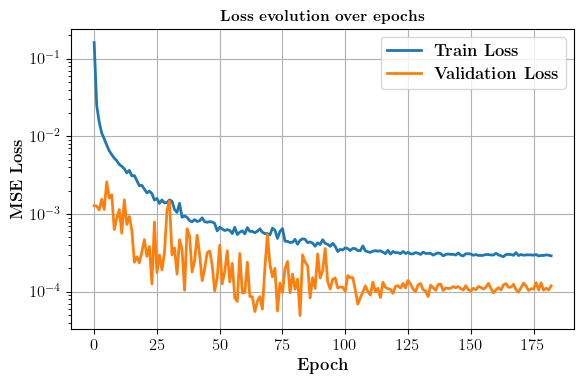

In [ ]:
# === Configuración de estilo LaTeX ===
plt.style.use('default')
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "font.family": "serif",
    "font.size": 12,
    "text.usetex": True,
    "axes.titlesize": 11
})

# === Crear carpeta para guardar ===
os.makedirs("LOSS_IMG", exist_ok=True)
loss_img_filename = model_name.replace(".pth", ".svg")
loss_img_path = os.path.join("LOSS_IMG", loss_img_filename)

# === Gráfico ===
plt.figure()
plt.plot(train_losses, label=r'\textbf{Train Loss}', linewidth=2)
plt.plot(val_losses, label=r'\textbf{Validation Loss}', linewidth=2)

plt.yscale("log")
plt.xlabel(r'\textbf{Epoch}')
plt.ylabel(r'\textbf{MSE Loss}')
plt.title(r'\textbf{Loss evolution over epochs}')
plt.legend()
plt.grid(True)
plt.tight_layout()

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(loss_img_path, format="svg")
plt.show()

## Carga de un modelo


In [ ]:

if config["load_model"]:
    from Data_loader import load_model_by_name
    
    model_filename = "3D_SAGE_Layers_4_HDim_128_Epochs_53_Lr_0.001366073_H_LOSS_False_Lambda_1.0_PI_False_Lambda_0.0001_Batch_64.pth"
    model = load_model_by_name(model, model_filename)
    print("Modelo cargado:", model_filename)


Modelo cargado desde: saved_models\3D_SAGE_Layers_4_HDim_128_Epochs_53_Lr_0.001366073_H_LOSS_False_Lambda_1.0_PI_False_Lambda_0.0001_Batch_64.pth
Modelo cargado: 3D_SAGE_Layers_4_HDim_128_Epochs_53_Lr_0.001366073_H_LOSS_False_Lambda_1.0_PI_False_Lambda_0.0001_Batch_64.pth


c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\ia_thermal\ernestoemedina3D\SAGE_3D\Data_loader.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_

## Evaluación

Evaluando en test set con visualización de un ejemplo:
Grafo 0: Data(x=[34, 2], edge_index=[2, 396], edge_attr=[396, 2], y=[34, 1], edge_attr_GLAGRA=[396, 2], edge_attr_norm=[396, 2], edge_attr_GLAGRA_norm=[396, 2], external_ids=[34], area=[34])


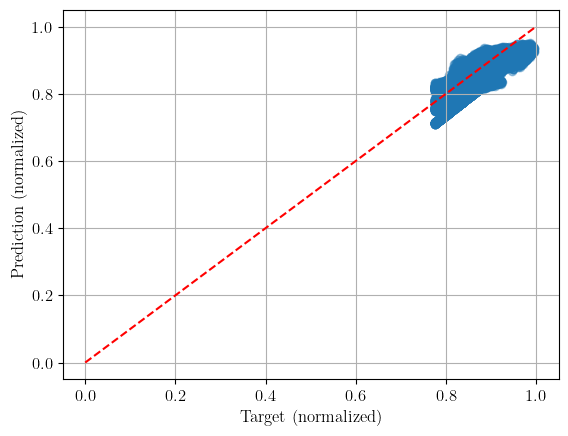

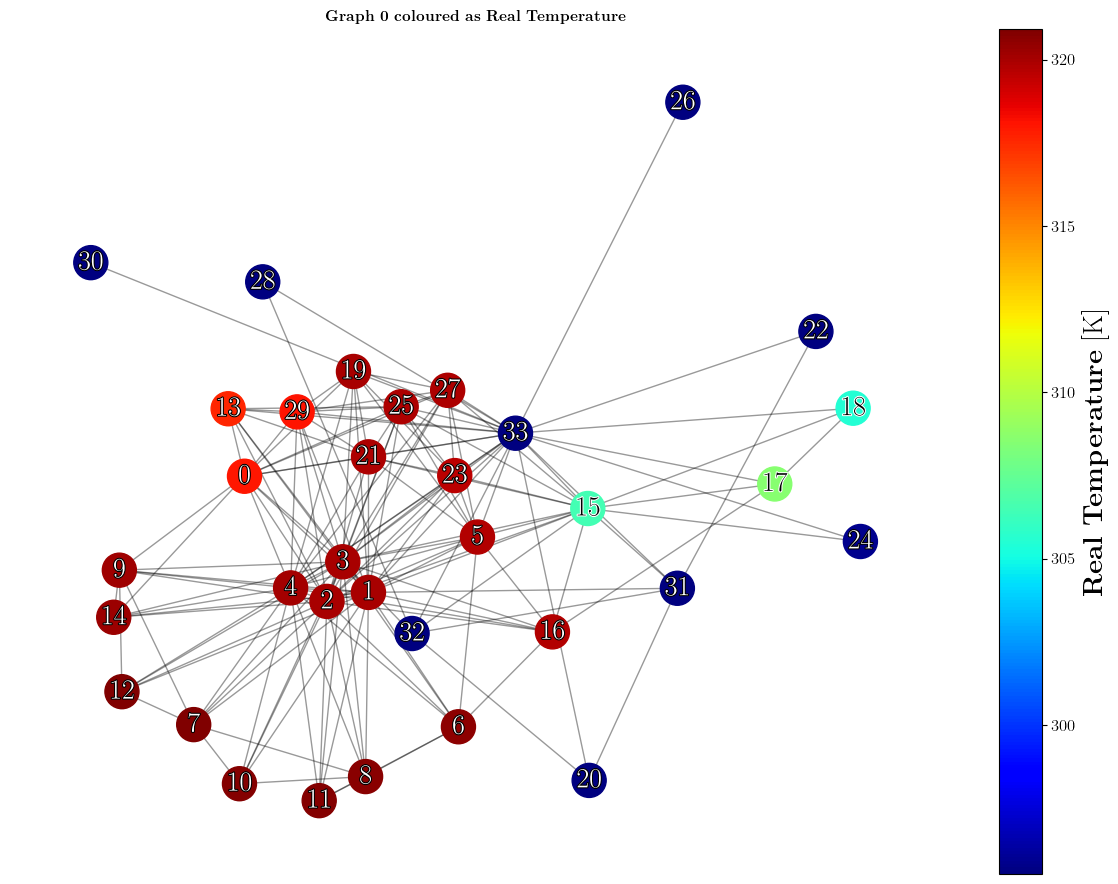

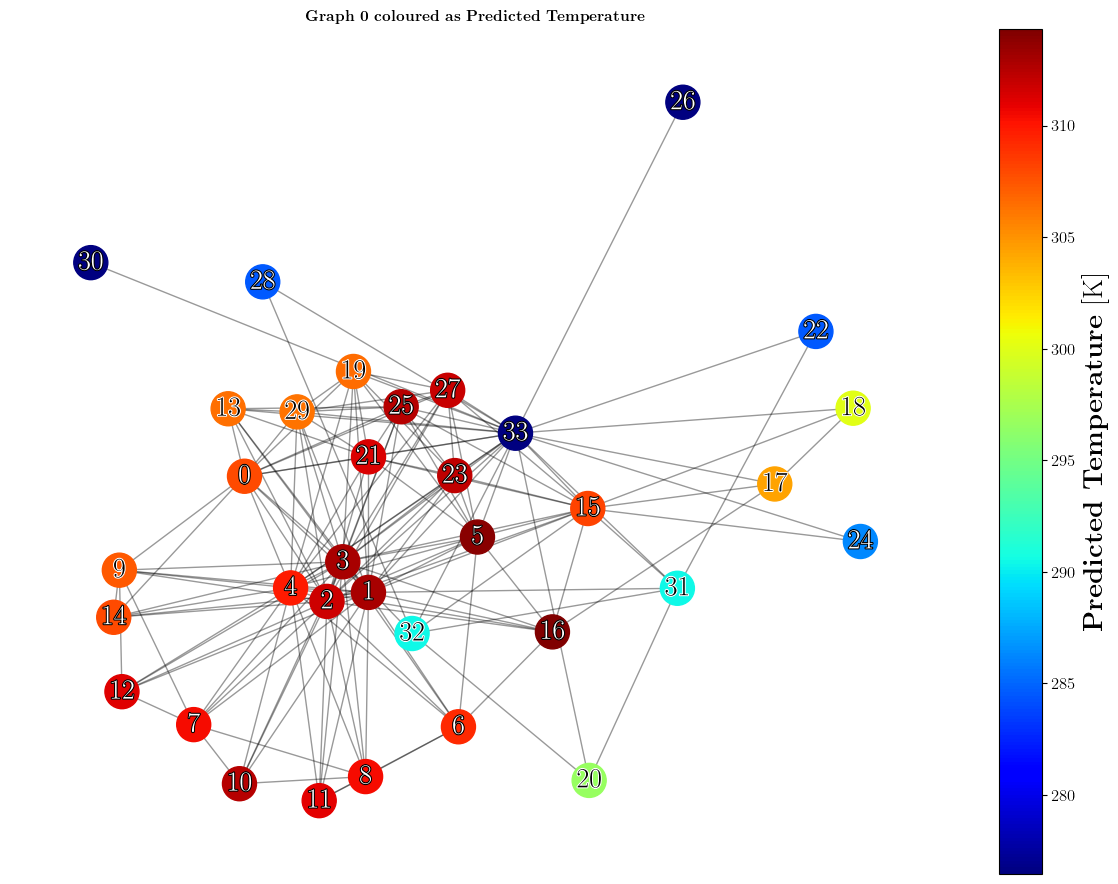

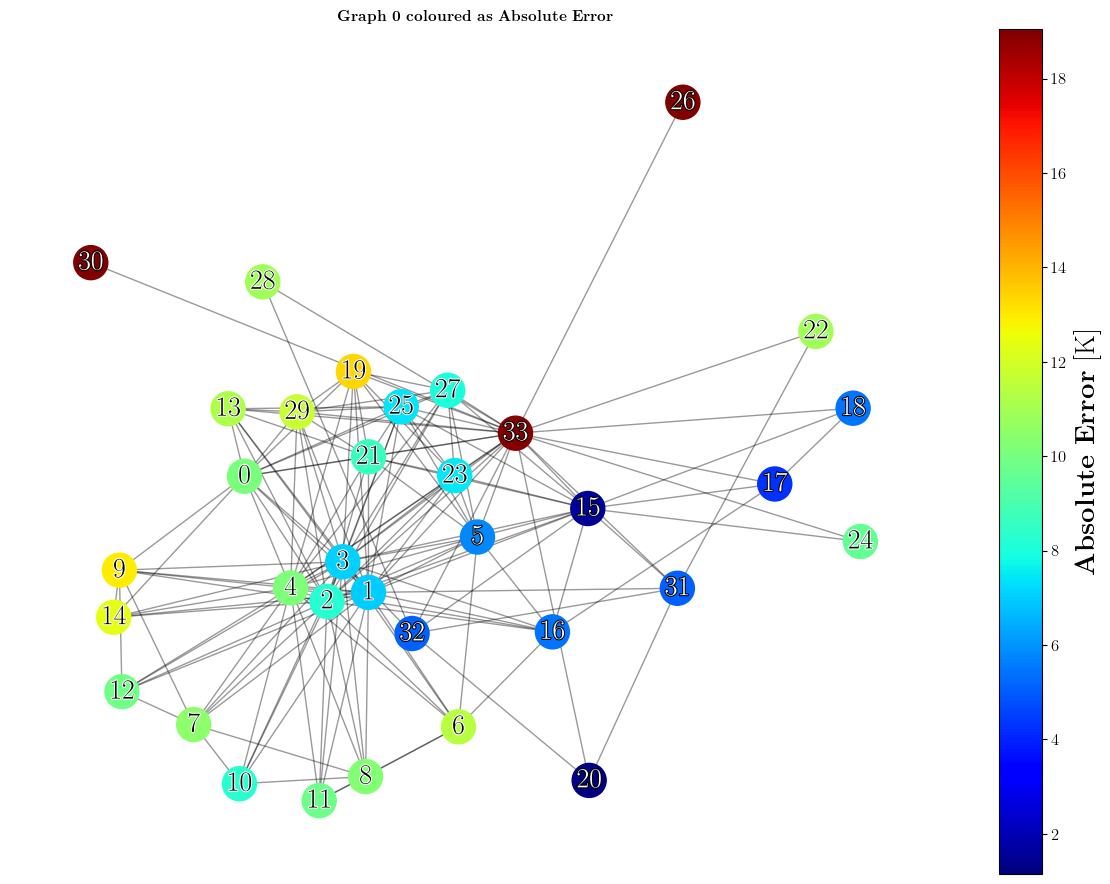

MAE en Kelvin     : 9.577 K
RMSE en Kelvin    : 10.708 K
MSE en Kelvin²    : 129.311 K²
Error máximo absoluto     : 30.928 K
Promedio de errores máximos por grafo: 21.568 K
Resultados del test:
MSE       : 0.001148
MAE       : 0.028532
R²        : -0.4529
Accuracy  : 16.73%
Heaters Loss  : 119.448488K²
Physics Loss  : 0.000000W²


In [10]:
# Evaluar en test y graficar un ejemplo
print("Evaluando en test set con visualización de un ejemplo:")
test_mse, test_mae, test_r2, test_accuracy, test_physics, test_heater, test_rmse, test_total_loss, max_error_K, mean_max_error_per_graph_K = evaluate(
    model, test_loader, device, norm_info, lambda_physics=config["lambda_physics"],
    use_physics=config["use_physics"], lambda_heater=config["lambda_heater"],
    use_heater_loss=config["use_heater_loss"],
    error_threshold_K=config["error_threshold_K"],
    plot_results=True
)

preds, targets = predict(model, test_loader, device, norm_info)
plt.figure()
plt.scatter(targets.numpy(), preds.numpy(), alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Target (normalized)")
plt.ylabel("Prediction (normalized)")
plt.grid(True)


physics_loss_str = f"{test_physics:.6f}" if test_physics is not None else "N/A"

max_T_real = norm_info["max_T_real"]
mae_K = test_mae * max_T_real
rmse_K = test_rmse * (max_T_real)
mse_K = test_mse * (max_T_real ** 2)
print(f"MAE en Kelvin     : {mae_K:.3f} K")
print(f"RMSE en Kelvin    : {rmse_K:.3f} K")
print(f"MSE en Kelvin²    : {mse_K:.3f} K²")
print(f"Error máximo absoluto     : {max_error_K:.3f} K")
print(f"Promedio de errores máximos por grafo: {mean_max_error_per_graph_K:.3f} K")

h_loss = test_heater * (max_T_real**2)

print("Resultados del test:")
print(f"MSE       : {test_mse:.6f}")
print(f"MAE       : {test_mae:.6f}")
print(f"R²        : {test_r2:.4f}")
print(f"Accuracy  : {test_accuracy:.2f}%")
print(f"Heaters Loss  : {h_loss:.6f}K²")
print(f"Physics Loss  : {physics_loss_str}W²")

## Guardado del mejor modelo

In [ ]:
# Crear carpeta si no existe
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Guardar el modelo
model_path = os.path.join(save_dir, model_name)
if config["save_model"]:
    # Guardar el modelo entrenado
    torch.save(model.state_dict(), model_path)

    print(f" Modelo guardado en: {model_path}")

 Modelo guardado en: saved_models\3D_SAGE_Layers_4_HDim_128_Epochs_83_Lr_0.000170759_H_LOSS_True_Lambda_1.0_PI_False_Lambda_0.0001_Batch_64.pth


## GNNExplainer

data.x.shape = torch.Size([34, 2])
data.edge_index.max() = 33
data.num_nodes = 34


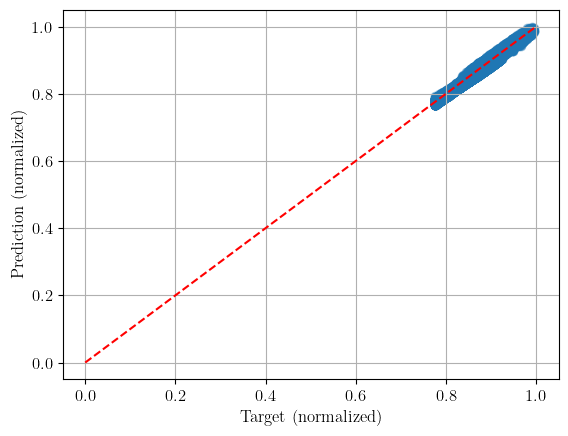

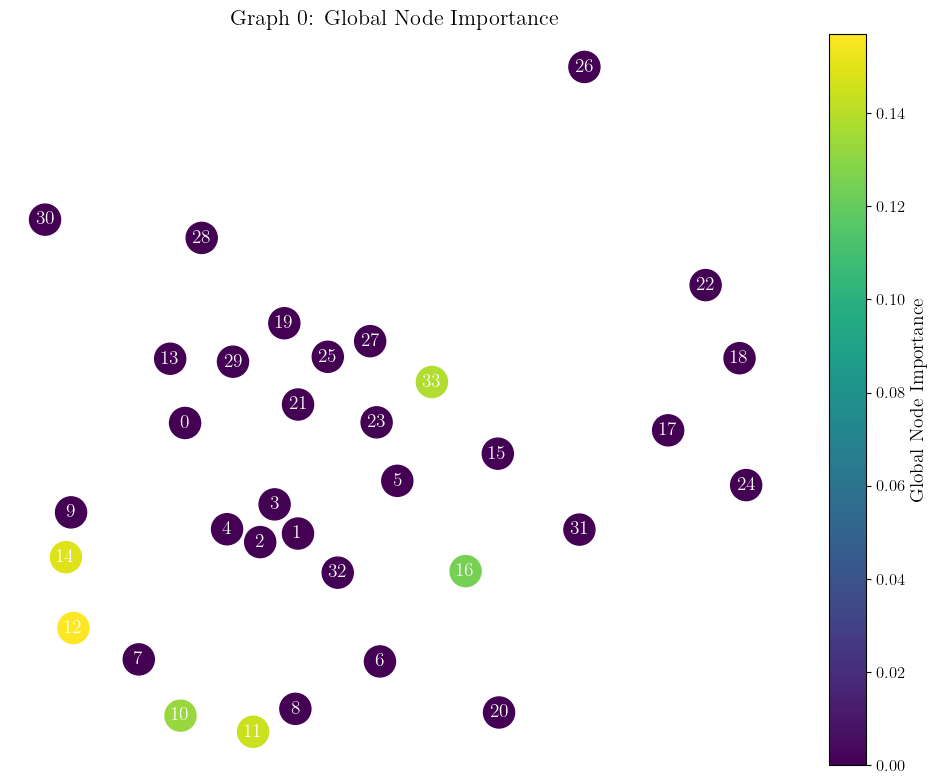

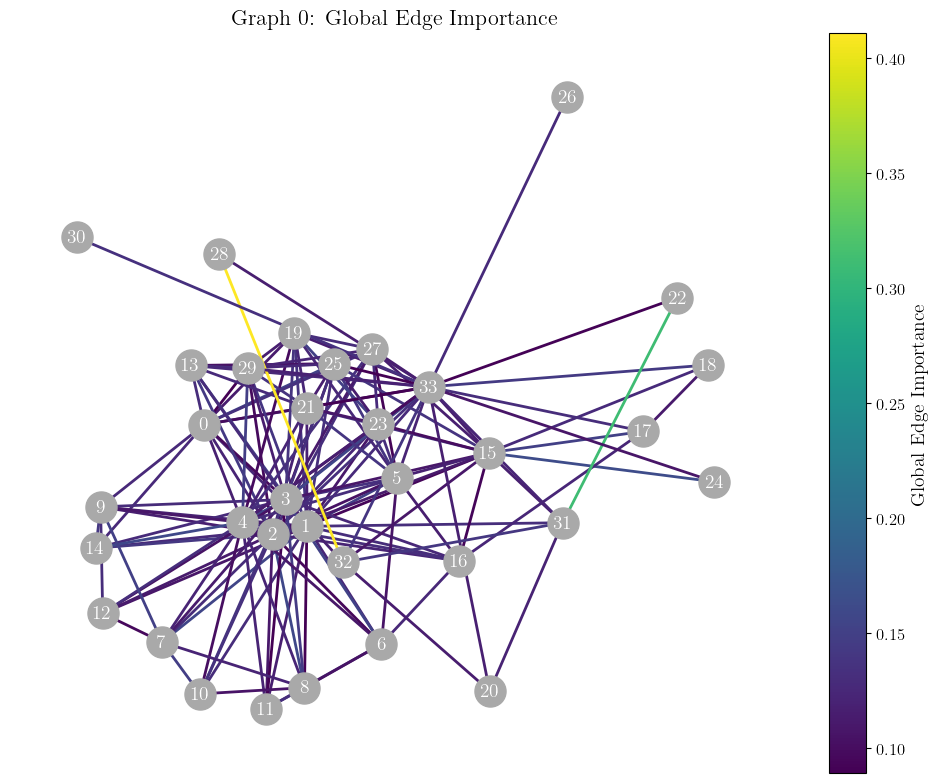

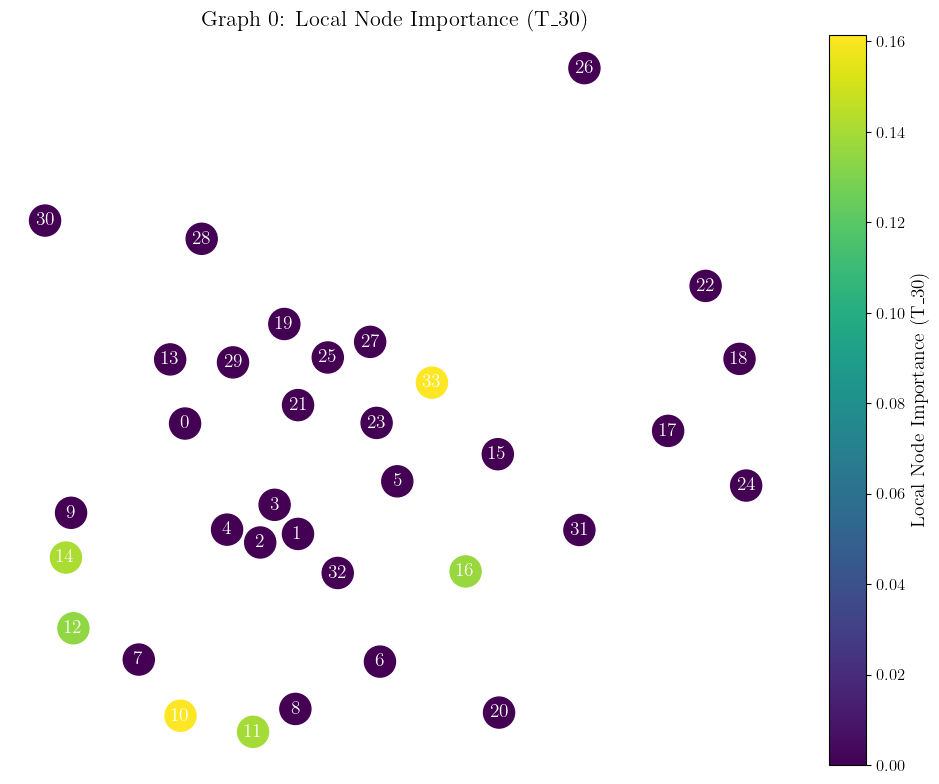

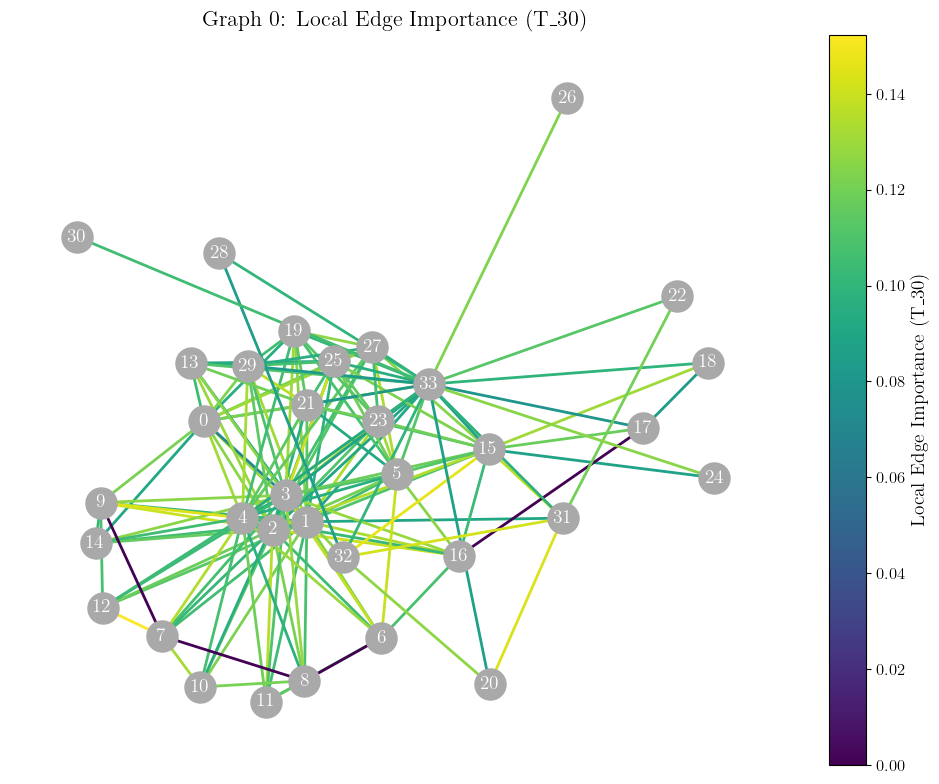

In [ ]:

run_full_gnnexplainer(model, test_loader.dataset, graph_idx=0, target_node_idx=30, norm_info=norm_info, device=device)